<a href="https://colab.research.google.com/github/sridevibonthu/EVA4Phase2/blob/master/Session12/Infer_caption_from_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
! git clone https://github.com/sridevibonthu/a-PyTorch-Tutorial-to-Image-Captioning

Cloning into 'a-PyTorch-Tutorial-to-Image-Captioning'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 275 (delta 0), reused 0 (delta 0), pack-reused 272
Receiving objects: 100% (275/275), 12.89 MiB | 42.86 MiB/s, done.
Resolving deltas: 100% (147/147), done.


In [3]:
mv a-PyTorch-Tutorial-to-Image-Captioning imgcap_tut

In [11]:
import gdown
import json

In [6]:
url = 'https://drive.google.com/uc?id=1x8p0vjKBnKjCDyBLm8GhC2IHIGCn6Lr7'
output = 'flickr8k_caption.encoder.scripted.pt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1x8p0vjKBnKjCDyBLm8GhC2IHIGCn6Lr7
To: /content/flickr8k_caption.encoder.scripted.pt
44.8MB [00:00, 74.6MB/s]


'flickr8k_caption.encoder.scripted.pt'

In [7]:
url = 'https://drive.google.com/uc?id=1wX4dJhr-i0spqRj5ge7I_IhngpRbNTFu'
output = 'flickr8k_caption.decoder.scripted.pt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1wX4dJhr-i0spqRj5ge7I_IhngpRbNTFu
To: /content/flickr8k_caption.decoder.scripted.pt
28.7MB [00:00, 172MB/s] 


'flickr8k_caption.decoder.scripted.pt'

In [8]:
url = 'https://drive.google.com/uc?id=1ZfIO5rKq06c3UFuokISAcoc7O_bYuDJW'
output = 'WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ZfIO5rKq06c3UFuokISAcoc7O_bYuDJW
To: /content/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json
100%|██████████| 41.3k/41.3k [00:00<00:00, 10.3MB/s]


'WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'

In [12]:
with open("/content/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json", "r") as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

In [13]:
encoder = torch.jit.load("/content/flickr8k_caption.encoder.scripted.pt")
decoder = torch.jit.load("/content/flickr8k_caption.decoder.scripted.pt")

In [29]:
from PIL import Image

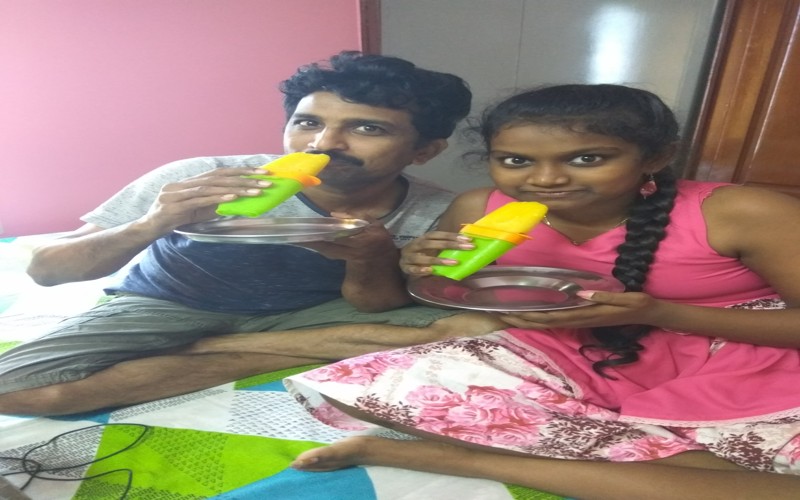

In [30]:
img = Image.open('sivavamsi.jpg')
img = img.resize((800, 500))
img

In [32]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as T
from PIL import Image

def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = Image.open(image_path)

    trans = T.Compose(
        [
            T.Resize((256, 256)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    image = trans(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(
        k, num_pixels, encoder_dim
    )  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.tensor([[word_map["<start>"]]] * k, dtype=torch.long) # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(
            encoder_out, h
        )  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(
            -1, enc_image_size, enc_image_size
        )  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(
            torch.cat([embeddings, awe], dim=1), (h, c)
        )  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        # import pdb; pdb.set_trace()
        seqs = torch.cat(
            [seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1
        )  # (s, step+1)
        seqs_alpha = torch.cat(
            [seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1
        )  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [
            ind
            for ind, next_word in enumerate(next_word_inds)
            if next_word != word_map["<end>"]
        ]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


In [34]:
with torch.no_grad():
    seq, alphas = caption_image_beam_search(encoder, decoder, "sivavamsi.jpg", word_map, beam_size=3)

In [35]:
seq

[2631, 14, 200, 226, 288, 197, 67, 1, 51, 492, 2632]

In [36]:
words = " ".join([rev_word_map[ind] for ind in seq if ind not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])

In [37]:
words

'two asian children are sitting on a pink bed'

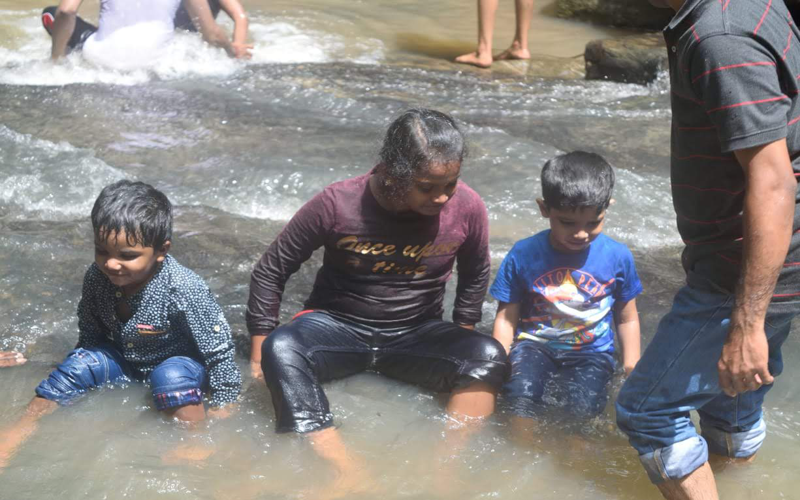

In [38]:
img = Image.open('kids.jpg')
img = img.resize((800, 500))
img

In [39]:
with torch.no_grad():
    seq, alphas = caption_image_beam_search(encoder, decoder, "kids.jpg", word_map, beam_size=3)
  
words = " ".join([rev_word_map[ind] for ind in seq if ind not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])

words

'four boys playing in a fountain'